In [14]:
import os
import re
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt

### Code

In [15]:
import lsst.daf.persistence as dafPersist
from pfs.datamodel.pfsConfig import TargetType
from pfs.drp.stella.utils.fiberThroughputs import estimateFiberThroughputs, plotThroughputs, throughputByVisit, throughputPerSpectrograph

In [16]:
#
# Workaround (harmless but annoying) pandas warning telling me to use sqlalchemy to access postgres
#
import warnings
import psycopg2
import pandas as pd

def pd_read_sql(sql_query: str, db_conn: psycopg2.extensions.connection) -> pd.DataFrame:
    """Execute SQL Query and get Dataframe with pandas"""
    with warnings.catch_warnings():
        # ignore warning for non-SQLAlchemy Connecton
        # see github.com/pandas-dev/pandas/issues/45660
        warnings.simplefilter('ignore', UserWarning)
        # create pandas DataFrame from database query
        df = pd.read_sql_query(sql_query, db_conn)
    return df

In [17]:
def butlerName(_butler=None):
    if _butler is None:
        _butler = butler
    root = _butler._repos.inputs()[0]._repoArgs.root
    root = re.sub(r"^.*/rerun/", "", root)
    
    return root

### Butler etc.

In [18]:
# See ~/pgpass
#   *:*:opdb:pfs:XXXX

if True:
    conn = psycopg2.connect("dbname='opdb' host='pfsa-db01' port=5432 user='pfs'") 
else:
    conn = None

In [19]:
butlers = {}

repo = "/projects/HSC/PFS/Subaru" if os.path.exists("/projects/HSC/PFS/Subaru") else "/work/drp" 

reruns = [
    "kiyoyabe/erun/run15/20240315",
    "rhl/tmp",
]
for rerun in reruns:
    kwargs = {}
    if rerun.startswith('/'):
        dataDir = rerun
    else:
        dataDir = os.path.join(repo, "rerun", rerun)

    if not os.path.exists(dataDir):
        continue

    print(dataDir)
    butlers[rerun] = dafPersist.Butler(dataDir, **kwargs)

if os.path.exists("/work/drp"):
    kwargs = {}
    repoRoot = "/work/drp"

    calibName = "CALIB-20220630"
    kwargs.update(calibRoot=os.path.join(repoRoot, calibName))
    rerun = f'drpActor/{calibName}'

    butlers["drp"] = dafPersist.Butler(os.path.join(repoRoot, 'rerun', rerun), **kwargs)

butler = butlers[list(butlers)[0]]   # default

dataId = dict(visit=83122 + 2, arm='b', spectrograph=1)

butlerName()

/work/drp/rerun/kiyoyabe/erun/run15/20240315
lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB-kiyoyabe-20240311/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB-kiyoyabe-20240311/calibRegistry.sqlite3
/work/drp/rerun/rhl/tmp
lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB-20220630/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB-20220630/calibRegistry.sqlite3


'kiyoyabe/erun/run15/20240315'

### "Spectrophotometry"

In [20]:
def missingCamera(arm, s=None):
    """Return True if a camera is known to be missing"""
    
    if s is None:
        dataId = arm
        arm, s = dataId["arm"], dataId["spectrograph"]
    
    return (arm == 'b' and s in [3]) or (arm == 'n' and s in [1, 4])

## Find data to process

In [21]:
startDate = '2024-03-09'

with conn:
        tmp = pd_read_sql(
            f'''
            SELECT DISTINCT ON (seq.sequence_type, vis.pfs_visit_id)
               vis.pfs_visit_id, seq.name, seq.iic_sequence_id,
               exp.exptime, exp.time_exp_start,
               pfs_visit.pfs_design_id
            FROM
               iic_sequence as seq
               JOIN visit_set AS vis ON seq.iic_sequence_id = vis.iic_sequence_id 
               JOIN iic_sequence_status AS sta ON seq.iic_sequence_id = sta.iic_sequence_id 
               JOIN sps_exposure AS exp ON vis.pfs_visit_id = exp.pfs_visit_id
               JOIN pfs_visit ON vis.pfs_visit_id = pfs_visit.pfs_visit_id
            WHERE
               seq.sequence_type = 'scienceObject' AND
               exp.time_exp_start >= '{startDate}' AND
               sta.status_flag = 0
            ORDER BY vis.pfs_visit_id
            ''', conn)

visits = tmp.pfs_visit_id.to_numpy()

# Look at fibre throughputs

In [22]:
#from pfs.drp.stella.utils.raster import addCobraIdCallback

from pfs.utils.butler import Butler as pButler
from pfs.utils.fiberids import FiberIds

pbutler = pButler(configRoot=os.path.join(os.environ["PFS_INSTDATA_DIR"], "data"))
pfi = pbutler.get('moduleXml', moduleName='ALL', version='')
gfm = FiberIds()

/software/mhs/products/Linux64/ics_cobraCharmer/1.4.9a/python/ics/cobraCharmer/pfiDesign.py:292: RuntimeWarning: divide by zero encountered in true_divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/mhs/products/Linux64/ics_cobraCharmer/1.4.9a/python/ics/cobraCharmer/pfiDesign.py:294: RuntimeWarning: divide by zero encountered in true_divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/mhs/products/Linux64/ics_cobraCharmer/1.4.9a/python/ics/cobraCharmer/pfiDesign.py:296: RuntimeWarning: divide by zero encountered in true_divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


In [23]:
if butlerName(butler) == "kiyoyabe/erun/run15/20240315":
    visits = [107178, 107318, 107319, 107640, 107645, 107646, 107649, 107650, 107653, 107656, 107658, 107660, 107661, 107671,
              107683, 107744, 107748, 107763, 107773, 107783, 107820, 107821, 107831, 107841, 107915, 107962, 107972, 107974,
              107978, 107983, 107985, 107995, 107997, 107999, 108009]
else:
    visits = sorted(set([
        107178, 107318, 107319, 107640, 107645, 107646, 107649, 107650, 107653, 107656, 107658,
        107660, 107661, 107671, 107672, 107673, 107683, 107684, 107706, 107707, 107717, 107734,
        107736, 107737, 107738, 107739, 107740, 107744, 107745, 107748, 107755, 107756, 107757,
        107758, 107759, 107760, 107761, 107762, 107763, 107765, 107766, 107767, 107768, 107769,
        107770, 107771, 107772, 107773, 107775, 107776, 107777, 107778, 107779, 107780, 107781,
        107782, 107783, 107792, 107820, 107821, 107823, 107824, 107825, 107826, 107827, 107828,
        107829, 107830, 107831, 107833, 107834, 107835, 107836, 107837, 107838, 107839, 107840,
        107841, 107843, 107865, 107866, 107867, 107868, 107898, 107915, 107943, 107944, 107945,
        107946, 107947, 107948, 107949, 107950, 107951, 107952, 107954, 107955, 107956, 107957,
        107958, 107959, 107960, 107961, 107962, 107964, 107965, 107966, 107967, 107968, 107969,
        107970, 107971, 107972, 107974, 107948, 107949, 107950, 107951, 107952, 107954, 107955,
        107956, 107957, 107958, 107959, 107960, 107961, 107962, 107964, 107965, 107966, 107967,
        107968, 107969, 107970, 107971, 107972, 107974, 107976, 107978, 107980, 107983, 107985,
        107987, 107988, 107989, 107990, 107991, 107992, 107993, 107994, 107995, 107997, 107998,
        107999, 108001, 108002, 108003, 108004, 108005, 108006, 108007, 108008, 108009, 108052,
        108074, 108081, 108082, 108083, 108084, 108085,
        # 108096, 108098, 108100, 108119, 108124, 108125, 108126, 108127, 108128, 108129, 
        # 108130, 108131, 108132, 108134, 108135, 108136, 108137, 108138, 108139, 108140, 
        # 108141, 108142, 
             ]))
    visits = [v for v in visits if v not in [107684, 107792, 107843, 107865, 107866, 107867, 107868,
                                             107898, 107976, 107980, 107980, 108052,
                                            ]]

arms = "rb"

what = "flux"         # show the flux in a wavelength band lam0 < lam < lam1
#what = "normedFlux"  # show the flux in a wavelength band lam0 < lam < lam1, divided by spec.norm
#what = "norm"        # show the fibre normalisation

try:
    cache
except NameError:
    cache = {}

cache = estimateFiberThroughputs(butler,  visits, arms="br", what="flux", cache=cache, verbose=1,
                                 missingCamera=lambda arm, s: (arm == 'b' and s in [3]) or (arm == 'n' and s in [1, 4]),
                                )

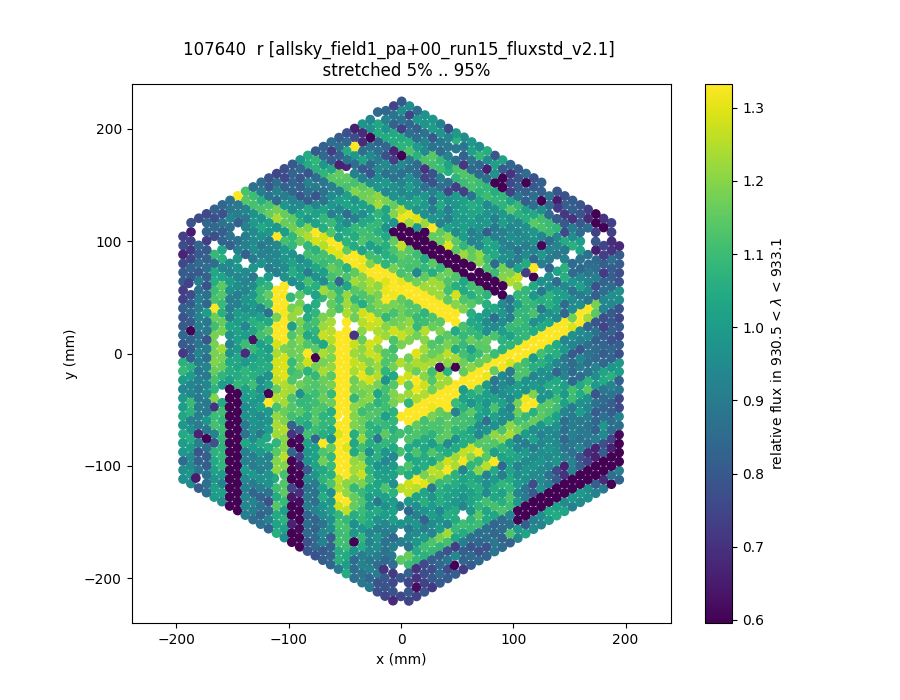

In [24]:
fig=8; plt.close(fig); fig = plt.figure(fig)

refVisit = 107717 if True else 107178
refVisit *= -1

normalizeArms = False  # use medianPerArm values (calculated in next cell) to normalise the arms/spectrographs
stretchToQlQh = True  # stretch to show the data between a high and low quantile, after normalising to the median
                      # else stretch in (0, 1) after normalising to the maximum
low, high = 5, 95

showHome = True     # show cobras at home, not pfiNominal, positions

plotThroughputs(cache, visits[3:][0:1], "br"[1], refVisit=refVisit, showHome=showHome, 
                stretchToQlQh=stretchToQlQh, low=low, high=high,
                pfi=pfi, gfm=gfm)

### As a function of visit

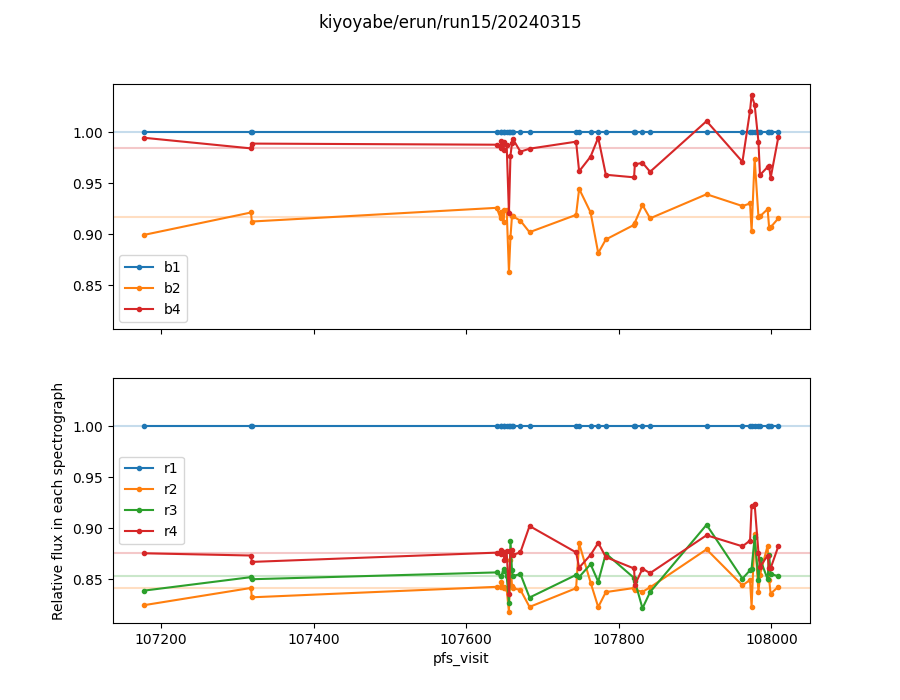

In [25]:
fig=1; plt.close(fig); fig = plt.figure(fig)

fig, medianPerArm = throughputByVisit(cache, "br", figure=fig, title=butlerName(butler))

## As a function of spectrograph/slit position

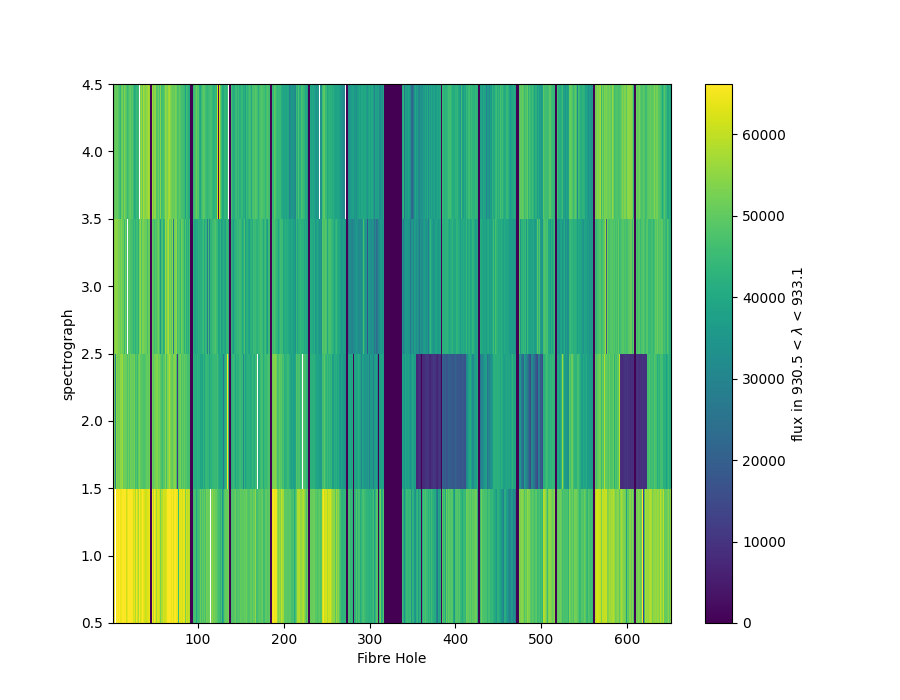

In [26]:
fig=2; plt.close(fig); fig = plt.figure(fig)

throughputPerSpectrograph(cache, visits[0], "r")